# Classifing hate speech tweets using logistic regression with Tf-Idf and Bag-of-Words vectorizers

## Loading the data set:

In [8]:
import numpy as np
import pandas as pd
import sklearn.model_selection as ms
import sklearn.feature_extraction.text as text
import matplotlib.pyplot as plt
import requests
import io
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
from string import punctuation
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

In [31]:
from datasets import load_dataset

dataset = load_dataset("tweets_hate_speech_detection")

Using custom data configuration default
Reusing dataset tweets_hate_speech_detection (C:\Users\maetu\.cache\huggingface\datasets\tweets_hate_speech_detection\default\0.0.0\c6b6f41e91ac9113e1c032c5ecf7a49b4e1e9dc8699ded3c2d8425c9217568b2)


  0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
# Downloading the csv file from GitHub
url = "https://raw.githubusercontent.com/Aaron9812/Data_mining/main/data/220505_train_data_preprocessed.csv"
download = requests.get(url).content

#df = pd.read_csv(url,index_col=0,parse_dates=[0])

# Reading the downloaded content and turning it into a pandas dataframe
df = pd.read_csv(io.StringIO(download.decode('utf-8')), sep=";")
print('File downloaded')
# Printing out the first row of the dataframe
print(df.columns)

File downloaded
Index(['id', 'label', 'tweet', 'n_mentions', 'hashtags', 'without_puctioation',
       'tweet_lower', 'tweet_token', 'clean_token', 'clean_hashtags',
       'stemmed_tokens', 'stemmed_hashtags', 'lemmatized_tokens',
       'lemmatized_hashtags', 'tfidf_stemmed_tokens', 'tfidf_stemmed_hashtags',
       'tfidf_lemmatized_tokens', 'tfidf_lemmatized_hashtags'],
      dtype='object')


In [32]:
#Not in use 
df = pd.DataFrame.from_dict(dataset['train'])
df.head()

,label,tweet
0,0,@user when a father is dysfunctional and is so...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [10]:
df.head()

,id,label,tweet,n_mentions,hashtags,without_puctioation,tweet_lower,tweet_token,clean_token,clean_hashtags,stemmed_tokens,stemmed_hashtags,lemmatized_tokens,lemmatized_hashtags,tfidf_stemmed_tokens,tfidf_stemmed_hashtags,tfidf_lemmatized_tokens,tfidf_lemmatized_hashtags
0,24090,0,best #lawofattraction #resources for #healing!...,0,"['lawofattraction', 'resources', 'healing', 'a...",best lawofattraction resources for healing ...,best lawofattraction resources for healing ...,"['lawofattraction', 'for', 'altwaystoheal', 'is']","['lawofattraction', 'altwaystoheal']","['lawofattraction', 'resources', 'healing', 'a...","['lawofattract', 'altwaystoh']","['lawofattract', 'resourc', 'heal', 'altwaysto...","['lawofattraction', 'altwaystoheal']","['lawofattraction', 'resource', 'healing', 'al...","[-54.797821044921875, 19.326093673706055]","[50.279502868652344, -0.368119478225708]","[30.39127540588379, -49.107627868652344]","[8.619098663330078, -19.02434539794922]"
1,15264,0,remembering to focus on the simplest happy mom...,0,"['blogger', 'blog', 'life']",remembering to focus on the simplest happy mom...,remembering to focus on the simplest happy mom...,"['to', 'on', 'simplest', 'moments', 'life', 'b...","['simplest', 'moments', 'life', 'blogger', 'li...","['blogger', 'blog', 'life']","['simplest', 'moment', 'life', 'blogger', 'life']","['blogger', 'blog', 'life']","['simplest', 'moment', 'life', 'blogger', 'life']","['blogger', 'blog', 'life']","[12.769611358642578, 38.40631866455078]","[-0.20247356593608856, -12.449955940246582]","[-25.304161071777344, -11.912176132202148]","[-5.459761619567871, -11.88219928741455]"
2,19310,0,when you get as happy as your boyfriend to be ...,0,['silvia'],when you get as happy as your boyfriend to be ...,when you get as happy as your boyfriend to be ...,"['you', 'as', 'as', 'boyfriend', 'be', 'with',...","['boyfriend', 'car']",['silvia'],"['boyfriend', 'car']",['silvia'],"['boyfriend', 'car']",['silvia'],"[15.18979263305664, -9.596672058105469]","[10.67345905303955, -4.716570854187012]","[80.47900390625, 3.222534656524658]","[-2.534292459487915, -6.132740020751953]"
3,27244,0,why do you always try to make me happy? i don...,0,"['love', 'devotion']",why do you always try to make me happy i dont...,why do you always try to make me happy i dont...,"['do', 'always', 'to', 'me', 'i', 'know', 'to'...","['always', 'know', 'love']","['love', 'devotion']","['alway', 'know', 'love']","['love', 'devot']","['always', 'know', 'love']","['love', 'devotion']","[-46.13848876953125, -18.032955169677734]","[11.31847858428955, -16.98657989501953]","[40.34811019897461, -24.527305603027344]","[8.227179527282715, -13.818502426147461]"
4,6633,0,omg is finally here!!! #ps4 #farcry4 #gtav #un...,0,"['ps4', 'farcry4', 'gtav', 'unchaed4']",omg is finally here ps4 farcry4 gtav unchaed4,omg is finally here ps4 farcry4 gtav unchaed4,"['is', 'here', 'farcry4', 'unchaed4']","['farcry4', 'unchaed4']","['ps4', 'farcry4', 'gtav', 'unchaed4']","['farcry4', 'unchaed4']","['ps4', 'farcry4', 'gtav', 'unchaed4']","['farcry4', 'unchaed4']","['ps4', 'farcry4', 'gtav', 'unchaed4']","[3.866750478744507, -5.09706449508667]","[21.51004409790039, 15.360187530517578]","[8.554491996765137, -20.749971389770508]","[-6.128843307495117, -11.832077980041504]"


In [15]:
features = [
"tweet",
"hashtags",
"without_puctioation",
"tweet_lower",
"tweet_token",
"clean_token",
"clean_hashtags",
"stemmed_tokens",
"stemmed_hashtags",
"lemmatized_tokens",
"lemmatized_hashtags"
]

In [16]:
X = df[features]
y = df.label
X.head()

,tweet,hashtags,without_puctioation,tweet_lower,tweet_token,clean_token,clean_hashtags,stemmed_tokens,stemmed_hashtags,lemmatized_tokens,lemmatized_hashtags
0,best #lawofattraction #resources for #healing!...,"['lawofattraction', 'resources', 'healing', 'a...",best lawofattraction resources for healing ...,best lawofattraction resources for healing ...,"['lawofattraction', 'for', 'altwaystoheal', 'is']","['lawofattraction', 'altwaystoheal']","['lawofattraction', 'resources', 'healing', 'a...","['lawofattract', 'altwaystoh']","['lawofattract', 'resourc', 'heal', 'altwaysto...","['lawofattraction', 'altwaystoheal']","['lawofattraction', 'resource', 'healing', 'al..."
1,remembering to focus on the simplest happy mom...,"['blogger', 'blog', 'life']",remembering to focus on the simplest happy mom...,remembering to focus on the simplest happy mom...,"['to', 'on', 'simplest', 'moments', 'life', 'b...","['simplest', 'moments', 'life', 'blogger', 'li...","['blogger', 'blog', 'life']","['simplest', 'moment', 'life', 'blogger', 'life']","['blogger', 'blog', 'life']","['simplest', 'moment', 'life', 'blogger', 'life']","['blogger', 'blog', 'life']"
2,when you get as happy as your boyfriend to be ...,['silvia'],when you get as happy as your boyfriend to be ...,when you get as happy as your boyfriend to be ...,"['you', 'as', 'as', 'boyfriend', 'be', 'with',...","['boyfriend', 'car']",['silvia'],"['boyfriend', 'car']",['silvia'],"['boyfriend', 'car']",['silvia']
3,why do you always try to make me happy? i don...,"['love', 'devotion']",why do you always try to make me happy i dont...,why do you always try to make me happy i dont...,"['do', 'always', 'to', 'me', 'i', 'know', 'to'...","['always', 'know', 'love']","['love', 'devotion']","['alway', 'know', 'love']","['love', 'devot']","['always', 'know', 'love']","['love', 'devotion']"
4,omg is finally here!!! #ps4 #farcry4 #gtav #un...,"['ps4', 'farcry4', 'gtav', 'unchaed4']",omg is finally here ps4 farcry4 gtav unchaed4,omg is finally here ps4 farcry4 gtav unchaed4,"['is', 'here', 'farcry4', 'unchaed4']","['farcry4', 'unchaed4']","['ps4', 'farcry4', 'gtav', 'unchaed4']","['farcry4', 'unchaed4']","['ps4', 'farcry4', 'gtav', 'unchaed4']","['farcry4', 'unchaed4']","['ps4', 'farcry4', 'gtav', 'unchaed4']"


In [17]:
(X_train, X_test, y_train, y_test) = ms.train_test_split(X, y, test_size=0.2, random_state = 17, stratify=y)

# Model Building:

In [33]:
# Definition des Label-Vektors
y = df['label']

## Using TF-IDF Vectorizer

In [34]:
# Definition der Feature-Matrix
tf = text.TfidfVectorizer()

X_vec = tf.fit(df['tweet'])
X = X_vec.transform(df['tweet'])

print(X.shape)

(31962, 41392)


### Split data into train and test data

In [35]:
#Not in use
# Splitting of data into training and test data
from sklearn.model_selection import train_test_split
(X_train, X_test, y_train, y_test) = ms.train_test_split(X, y, test_size=0.2, random_state = 17, stratify=y)

In [36]:
# Testing Stratification
print('There is {} training data, of which {}% is hate speech '.format(y_train.count(), round(y_train.sum()/y_train.count()*100,2)))
print('There is {} test data, of which {}% is hate speech '.format(y_test.count(), round(y_test.sum()/y_test.count()*100,2)))

There is 25569 training data, of which 7.02% is hate speech 
There is 6393 test data, of which 7.01% is hate speech 


### Train Model

In [37]:
def simple_logistic_classify(X_tr, y_tr, X_test, y_test, _C=1.0):
    model = LogisticRegression(C=_C).fit(X_tr, y_tr)
    score = model.score(X_test, y_test)
    print('Test Score:', score)
    return model

In [38]:
model = simple_logistic_classify(X_train, y_train, X_test, y_test)

Test Score: 0.9465039887376818


### Evaluate Performance of the Model using  a Tf-Idf vectorizer

In [39]:
def evaluation(xTest, yTest, vectorizer):
    print('Results for Logistic Regression using a ' + str(vectorizer) + ' vectorizer:')
    print(f'The hit rate with the simple logistic regression is approx. {round(100*model.score(xTest, yTest),2)}%')
    print('Precision: %.3f' % precision_score(yTest, model.predict(xTest)))
    print('Recall: %.3f' % recall_score(yTest, model.predict(xTest)))
    print('Accuracy: %.3f' % accuracy_score(yTest, model.predict(xTest)))
    print('F1 Score: %.3f' % f1_score(yTest, model.predict(xTest)))

In [40]:
evaluation(X_test, y_test, 'Tf-Idf')

Results for Logistic Regression using a Tf-Idf vectorizer:
The hit rate with the simple logistic regression is approx. 94.65%
Precision: 0.942
Recall: 0.252
Accuracy: 0.947
F1 Score: 0.398


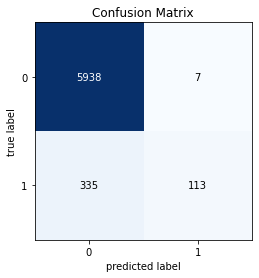

In [86]:
# Confusion-Matrix
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(y_test, model.predict(X_test))

fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.title("Confusion Matrix")
plt.show()

# Using a BoW Vectorizer

In [87]:
bow_converter = CountVectorizer()

Xc = bow_converter.fit_transform(df['tweet'])

print(Xc.shape)

(31962, 41392)


### Split Data

In [88]:
# Splitting of data into training and test data
(Xc_train, Xc_test, yc_train, yc_test) = ms.train_test_split(Xc, y, test_size=.2, random_state = 17)

### Train Model

In [89]:
bow_model = simple_logistic_classify(Xc_train, yc_train, Xc_test, yc_test)

Test Score: 0.9641795714062256


C:\Users\maetu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Evaluate Model Performance based on BOW Vectorizer

In [92]:
evaluation(Xc_test, yc_test, 'BoW')

Results for Logistic Regression using a BoW vectorizer:
The hit rate with the simple logistic regression is approx. 89.32%
Precision: 0.375
Recall: 0.893
Accuracy: 0.893
F1 Score: 0.528


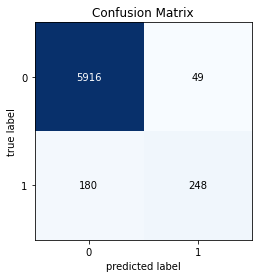

In [93]:
# Confusion-Matrix
cm = confusion_matrix(yc_test, bow_model.predict(Xc_test))

fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.title("Confusion Matrix")
plt.show()

# Regression using upsampled data

In [41]:
# Train vectorizer BEFORE upsampling
tf = text.TfidfVectorizer(stop_words='english')
X_tf_vec = tf.fit(df['tweet'])
#X_tf_vec = tf.fit(df['no_user'])

co = text.CountVectorizer(stop_words='english')
X_co_vec = co.fit(df['tweet'])
#X_co_vec = co.fit(df['no_user'])

In [42]:
# Prepare Split data
y = df['label']
X = df['tweet']
#X = df['no_user']

In [43]:
# Split data BEFORE upsampling
(X_train, X_test, y_train, y_test) = ms.train_test_split(X, y, test_size=0.2, random_state = 17, stratify=y)

df_train = pd.concat([y_train,X_train], axis=1)
df_test = pd.concat([y_test,X_test], axis = 1)
df_train.head()

,label,tweet
30405,0,when everyone's free when you're in exam mode ...
27807,0,#jacksonville rooster simulation: i want to ...
8660,0,@user just run 10kms for @user @user #loveis...
19185,0,@user got the prototype for our new usb today!...
10355,0,have a &amp; #healthy #fathersday. #runnerda...


In [44]:
data_minority = df_train[df_train.label == 1]
data_majority = df_train[df_train.label == 0]

print("length majority", len(data_majority))
print("length minority", len(data_minority))

length majority 23775
length minority 1794


In [45]:
from sklearn.utils import resample
data_minority = resample(data_minority, replace = True, n_samples=23775, random_state=55)

In [46]:
df_train_up = pd.concat([data_majority, data_minority])
df_train_up.label.value_counts()

0    23775
1    23775
Name: label, dtype: int64

In [47]:
# create embeddings

# tfifd
Xt_train = X_tf_vec.transform(df_train_up['tweet'])
Xt_test = X_tf_vec.transform(df_test['tweet'])

# count vectorizer
Xc_train = X_co_vec.transform(df_train_up['tweet'])
Xc_test = X_co_vec.transform(df_test['tweet'])

# labels
y_train = df_train_up['label']
y_test = df_test['label']

print(Xt_train.shape) 

(47550, 41104)


In [48]:
# Testing Stratification
print('There is {} training data, of which {}% is hate speech '.format(df_train_up['label'].count(), round(df_train_up['label'].sum()/df_train_up['label'].count()*100,2)))
print('There is {} test data, of which {}% is hate speech '.format(df_test['label'].count(), round(df_test['label'].sum()/df_test['label'].count()*100,2)))

There is 47550 training data, of which 50.0% is hate speech 
There is 6393 test data, of which 7.01% is hate speech 


## Model Building

In [51]:
''' #TF-IDF
# Multi-variate Bernoulli Naive Bayes
bnb = ms.GridSearchCV(nb.BernoulliNB(), param_grid={'alpha':np.logspace(-2., 2., 50)})
bnb.fit(Xt_train, y_train);

# Multinominal Naive Bayes
mnb = ms.GridSearchCV(nb.MultinomialNB(), param_grid={'alpha':np.logspace(-2., 2., 50)})
mnb.fit(Xt_train, y_train);

# Count Vectorizer
# Multi-variate Bernoulli Naive Bayes
cbnb = ms.GridSearchCV(nb.BernoulliNB(), param_grid={'alpha':np.logspace(-2., 2., 50)})
cbnb.fit(Xc_train, y_train);

# Multinominal Naive Bayes
cmnb = ms.GridSearchCV(nb.MultinomialNB(), param_grid={'alpha':np.logspace(-2., 2., 50)})
cmnb.fit(Xc_train, y_train); '''

#Tf-Idf vectorizer
model = simple_logistic_classify(Xt_train, y_train, Xt_test, y_test)

#BoW vectorizer
bow_model = simple_logistic_classify(Xc_train, y_train, Xc_test, y_test)

Test Score: 0.9530736743312999
Test Score: 0.9579227279837322


C:\Users\maetu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [54]:
evaluation(Xc_test, y_test, 'BoW')
evaluation(Xt_test, y_test, 'Tf-Idf')

Results for Logistic Regression using a BoW vectorizer:
The hit rate with the simple logistic regression is approx. 84.86%
Precision: 0.302
Recall: 0.886
Accuracy: 0.849
F1 Score: 0.451
Results for Logistic Regression using a Tf-Idf vectorizer:
The hit rate with the simple logistic regression is approx. 95.31%
Precision: 0.642
Recall: 0.748
Accuracy: 0.953
F1 Score: 0.691


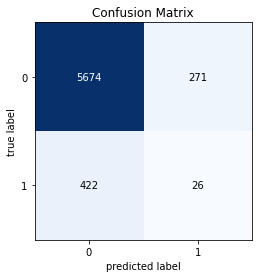

In [100]:
# Confusion-Matrix
cm = confusion_matrix(y_test, bow_model.predict(Xc_test))

fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.title("Confusion Matrix")
plt.show()

## Results:
- first results the best so far
- Upsampling lowered the f1 score for BoW
- Upsampling increased the f1 score for Tf-Idf